In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import random
import os
from scipy import signal
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
import matplotlib
from matplotlib import pyplot as plt
from scipy import signal
import gc



print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.7.0
Keras Version: 2.7.0

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
Pandas 1.3.4
Scikit-Learn 1.0.1
GPU is available


Globals

In [2]:
cwd = os.getcwd()
FREQ = 500
database_path = 'Dataset/CHB-MIT/chb-mit-scalp-eeg-database-1.0.0/'
filtered_database_path = 'Dataset/CHB-MIT/Filtered-chb-mit/'
external_hardisk_drive_path = os.path.dirname('/Volumes/LaCie/Database/')
edf_file_type = ".edf"
compressed_file_type = ".parquet.gzip"
file = "/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/ECG/patient_4_date_2019-05-20 1102590000.csv"


In [3]:
def get_info_text():
    with open("/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/EEG/info.txt", 'r') as f:
        str_container = ""
        formatted_str = []
        for line in f:
            str_container += str(line).replace("\n", "<br>")
            formatted_str = re.findall('(.*?)<br><br>', str_container)
        return formatted_str

info_obj = get_info_text()
        

In [4]:
names = "/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/ECG/Seizure/Seizure_0_patient_4_date_2019-05-20 1102590000.csv"

In [5]:
def find_frq(str_obj):
    frq_found = re.search(r"<br> freq: (.*?) <br>", str_obj)
    if(frq_found):
        return int(float(frq_found.group(1)))

def find_filename(str_obj):
    frq_found = re.search(r"filename: (.*?) <br>", str_obj)
    if(frq_found):
        return (frq_found.group(1))

find_frq("filename: patient_4_date_2019-05-21 1556430000 <br> freq: 500.0 <br> channels: ['CH-1', 'CH-2', 'CH-3', 'CH-4', 'CH-5', 'CH-6', 'CH-7', 'CH-8', 'x', 'y', 'z'] ")

500

In [6]:
FREQ = [find_frq(x) for x in info_obj if find_filename(x) in names][0] if len([find_frq(x) for x in info_obj if find_filename(x) in names]) > 0 else 500

In [7]:
def remove_cols(dataframe, col_start = 0, col_end = 0):
    if col_end == 0:
        col_end = len(dataframe.columns) - 1
    
    dataframe = dataframe.iloc[: , col_start: col_end]
    return dataframe

In [8]:
os.getcwd()

'/Users/niklashjort/Desktop/Notes/Speciale/projects/DataHandling/Køge/Jupyter'

In [9]:
for f in os.listdir("/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/ECG"):
    print(f)

.DS_Store
info.txt
Seizure
Interictal
Preictal


In [10]:
df = pd.read_csv("/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/EEG/Seizure/Seizure_0_patient_24_date_2020-11-02 0949020000.csv", usecols=[1,2,3, 4])

In [11]:
df.columns

Index(['Fp1-Ref', 'Fp2-Ref', 'timestamp', 'class'], dtype='object')

In [12]:
gc.collect()

30

In [13]:
# print(test_df.info(memory_usage='deep'))
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [14]:
df.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19500 entries, 0 to 19499
Columns: 4 entries, Fp1-Ref to class
dtypes: float64(4)
memory usage: 609.5 KB


In [15]:
mem_usage(df)

'0.60 MB'

In [16]:
df.dtypes

Fp1-Ref      float64
Fp2-Ref      float64
timestamp    float64
class        float64
dtype: object

In [17]:
df.head()

,Fp1-Ref,Fp2-Ref,timestamp,class
0,0.010736,0.029716,1.604433e+12,1.0
1,0.010952,0.029939,1.604433e+12,1.0
2,0.011067,0.030052,1.604433e+12,1.0
3,0.011043,0.030025,1.604433e+12,1.0
4,0.010867,0.029846,1.604433e+12,1.0


In [18]:
def downcast_dtypes(df):
    _start = df.memory_usage(deep=True).sum() / 1024 ** 2
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype in ['int64', 'int32']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    _end = df.memory_usage(deep=True).sum() / 1024 ** 2
    saved_time = (_start - _end) / _start * 100
    #print(f"Saved: {saved_time:.2f}%")
    return df

In [19]:
df = downcast_dtypes(df)

In [20]:
df['class'].value_counts()

1.0    19500
Name: class, dtype: int64

In [21]:
df.head()

,Fp1-Ref,Fp2-Ref,timestamp,class
0,0.010736,0.029716,1.604433e+12,1.0
1,0.010952,0.029939,1.604433e+12,1.0
2,0.011067,0.030052,1.604433e+12,1.0
3,0.011043,0.030025,1.604433e+12,1.0
4,0.010867,0.029846,1.604433e+12,1.0


In [22]:
df['class'] = df['class'].astype('int32')

In [23]:
def read_compressed_df(df):

    sz_df = df.loc[df['class'] == 1]

    prei_one_df = df.loc[df['class'] == 2]

    inter_df = df.loc[df['class'] == 3]

    channels = [item for item in list(sz_df.columns) if item != "class" if item != "timestamp"]

    return (sz_df, prei_one_df, inter_df, channels)

In [24]:
def get_window(channel, start_index, data, size = 4, overlap = 0, is_sezure = False, frequency = 500):
    if(is_sezure):
        overlap = 2
    else:
        overlap = overlap
    
    start = start_index * (size - overlap) * frequency
    end = start + (size * frequency)

    date_timestamp = ""

    try:
        date_timestamp = datetime.fromtimestamp((data['timestamp'][start:start+1]/1000).tolist()[0]).strftime('%H:%M:%S')
    except:
        date_timestamp = "datetime cannot be converted"
    
    return [data[channel][start:end].tolist(), date_timestamp]

In [25]:
def get_max_window_iteration(dataframe, buffer):
    len_of_df = int(len(dataframe) // (buffer*FREQ))
    return len_of_df


In [26]:
Fs = 500             # Define the sampling frequency,
interval = Fs        # ... the interval size,
overlap = Fs * 0.95  # ... and the overlap intervals

def spec_transform_save_to_folder(index, win, channel, patient_state, patient, plot_title = False):
    plt.figure(figsize=(7,7))
    series = win[0]
    time_of_observation = win[1]
    try:
        series = np.array(series).astype(np.float)
    except Exception as e:
        print(f"error: {e}")
        print(f"patient_state: {patient_state} channel: {channel} index: {index} window: {series}")
    denoised_series = denoise_wavelet(series, method='BayesShrink', mode='soft',rescale_sigma=True, multichannel=False, wavelet_levels=3)
    if plot_title:
        plt.title(f"{channel} : is_seizure = {patient_state} : {time_of_observation}")
    

    f, t, Sxx = signal.spectrogram(denoised_series, fs=Fs, nperseg=interval, noverlap=overlap)
                         
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='jet')



    #s,f,t,im = plt.specgram(denoised_series,Fs=256)
    #plt.ylim(0, 20)
    #plt.axis('off')
    
    # f, t, Sxx = signal.spectrogram(denoised_series, 1./FREQ, nfft=overlap, nperseg=int(256/2))
    # #plt.pcolormesh(t, f[0:20], Sxx[0:20])
    # plt.pcolormesh(t, f, 10*np.log10(Sxx))
    plt.show()
    # if patient_state == "seizure":
    #     plt.savefig(f'test_data//windows/Seizure2/{patient}_{index}_{channel}_{time_of_observation}.png', edgecolor='none', bbox_inches='tight')
    # elif patient_state == "interictal":
    #     plt.savefig(f'test_data//windows/Interictal/{patient}_{index}_{channel}_{time_of_observation}.png')
    # elif patient_state == "prei_one":
    #     plt.savefig(f'test_data//windows/test/Preictal_One/{patient}_{index}_{channel}_{str(time_of_observation).strip()}.png')
    # elif patient_state == "prei_two":
    #     plt.savefig(f'test_data/windows/Preictal_Two/{patient}_{index}_{channel}_{str(time_of_observation).strip()}.png')
    # plt.show()
    del series
    plt.clf()    
    plt.close()
    gc.collect()

In [27]:
lst = [6, 6, 5, 6, 7, 11, 10, 9, 9, 8, 13, 13, 13, 13, 14]

new_list = []

def Average(lst):
    return sum(lst) / len(lst)

[[Average(lst[i:i+5]) for i in range(0, len(lst), 5)], [max(lst[i:i+5]) for i in range(0, len(lst), 5)], [min(lst[i:i+5]) for i in range(0, len(lst), 5)]]


[[6.0, 9.4, 13.2], [7, 11, 14], [5, 8, 13]]

In [28]:
sys.path.append("/Users/niklashjort/Desktop/Notes/Speciale/projects/DataHandling/Køge/")


In [29]:
from spectrogram_proj.spectrogram import multitaper_spec_save_to_folder, spec_save_to_folder, nanpow2db

In [30]:
import pandas as pd
x = [[1,2], [1,2], [1,4]]

d = pd.DataFrame(x, columns=['loss', 'profit'])

d.insert(0, "diff", [d['profit'][i] - d['loss'][i] for i in d.index])

d.head()

,diff,loss,profit
0,1,1,2
1,1,1,2
2,3,1,4


In [31]:
count = 0

print("started file: " + str(file) + " index: " + str(count))
sz, prei_one, inter, selected_channels = read_compressed_df(df)
print(selected_channels)
print(f"len sz {len(sz)}")
print(f"len prei {len(prei_one)}")
patient = re.search('patient_(.*)_date_', file).group(1)
print(patient)
sz_count = 0
int_count = 0
prei_count = 0
count = 0
sz_win = []
inter_win =[]
for channel in selected_channels:
    if count < 1:
        if len(inter) > 0 and inter.empty == False and int_count < 3:
            inter_win = [get_window(channel=channel,start_index=i, data=inter) for i in range(get_max_window_iteration(inter, 4))]
            # for index, window in enumerate(inter_win):
            #     if int_count > 1:continue
            #     spec_transform_save_to_folder(win=window, index=index, channel=channel, patient_state = "interictal", patient=patient, plot_title=True)
            #     int_count += 1
        if len(prei_one) > 0 and prei_one.empty == False and prei_count < 3:
            prei_win = [get_window(channel=channel, start_index=i, data=prei_one, is_sezure=True) for i in range(get_max_window_iteration(prei_one, 2))]
            for index, window in enumerate(prei_win):
                if prei_count > 1:continue
                prei_count += 1
                multitaper_spec_save_to_folder(channel=channel, index=index, win=window, patient_state="preictal", patient=patient, plot_title=True, save_path="")

        if len(sz) > 0 and sz.empty == False and sz_count < 3:
            sz_win = [get_window(channel=channel, start_index=i, data=sz, is_sezure=True) for i in range(get_max_window_iteration(sz, 2))]
            # for index, window in enumerate(sz_win):
            #     if sz_count > 1:continue
            #     sz_count += 1
            #     spec_transform_save_to_folder(channel=channel, index=index, win=window, patient_state="seizure", patient=patient, plot_title=True)
            
        count += 1


#del sz, prei_one, inter, df

started file: /Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/ECG/patient_4_date_2019-05-20 1102590000.csv index: 0
['Fp1-Ref', 'Fp2-Ref']
len sz 19500
len prei 0
4


In [32]:
def butter_highpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    y = signal.lfilter(b, a, data)
    return y

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    i, u = signal.butter(order, [low, high], btype='bandstop')
    y = signal.lfilter(i, u, data)
    return y

def apply_filter(series, FREQ):
    series = butter_bandstop_filter(series, 97, 103, FREQ, order=6)
    series = butter_bandstop_filter(series, 47, 53, FREQ, order=6)
    series = butter_highpass_filter(series, 1, FREQ, order=6)
    return series

/Users/niklashjort/Desktop/Notes/Speciale/projects/DataHandling/Køge/spectrogram_proj/spectrogram.py:338: UserWarning: Number of tapers is optimal at floor(2*TW) - 1. consider using 9
  warnings.warn('Number of tapers is optimal at floor(2*TW) - 1. consider using ' +
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


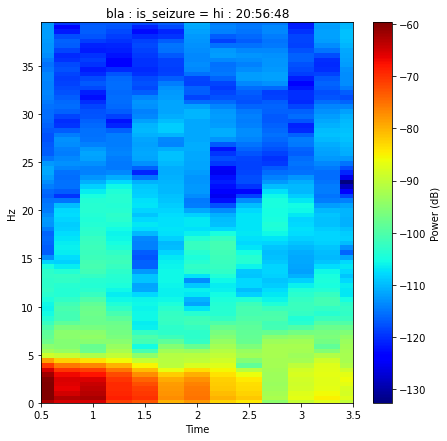

SUCCES - patient: 5 time: 20-56-48


In [33]:
sys.path.append("/Users/niklashjort/Desktop/Notes/Speciale/projects/DataHandling/Køge/")
from spectrogram_proj.spectrogram import multitaper_spec_save_to_folder
multitaper_spec_save_to_folder(channel="bla", patient=5, patient_state="hi", save_path="", index=1, win=sz_win[10], decorate=True)


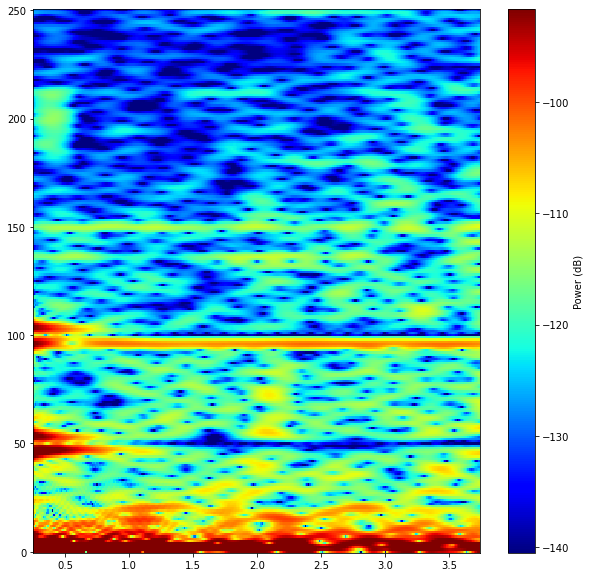

SUCCES - patient: 5 time: 20-56-48


In [34]:
from spectrogram_proj.spectrogram import spec_save_to_folder
plt.figure(figsize=(10,10))
spec_save_to_folder(channel="bla", patient=5, patient_state="hi", save_path="", index=1, win=sz_win[10])

In [35]:
Fs = 256         # Define the sampling frequency,
interval = 256       # ... the interval size,
overlap = interval * 0.99  # ... and the overlap intervals

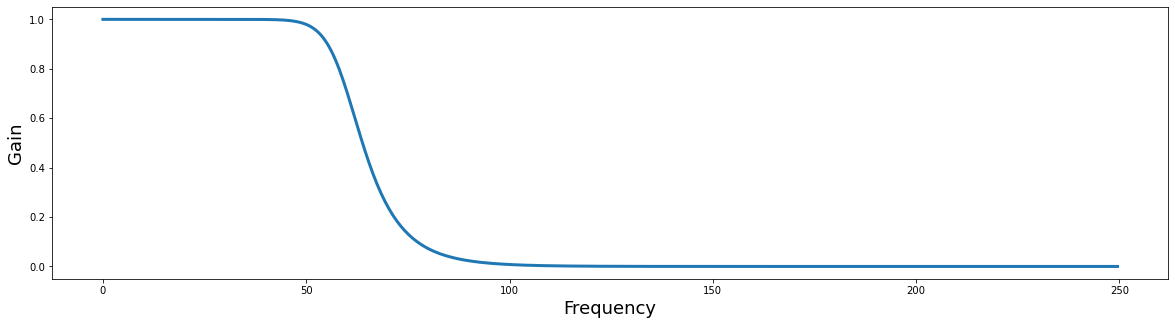

In [36]:
filter_order = 8
frequency_cutoff = 60
sampling_frequency = 500

def rad_sample_to_hz(x, fs):
    return (x*fs)/(2*np.pi)

def plot_filter(b, a, fs):
    plt.figure(figsize=(20,5))
    w, h = signal.freqz(b, a, worN=256*2, whole=False)
    plt.plot(rad_sample_to_hz(w, fs), abs(h), linewidth=3)
    plt.ylabel('Gain', fontsize=18)
    plt.xlabel('Frequency', fontsize=18)

# Create the filter
b, a = signal.butter(8, frequency_cutoff, btype='low', output='ba', fs=sampling_frequency)
plot_filter(b, a, sampling_frequency)

In [37]:
# Apply the filter
filtered = signal.filtfilt(b, a, sze)

plt.figure(figsize=(20,5))
plt.plot(sze, linewidth=2)
plt.plot(filtered, linewidth=4)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Original','Filtered'], fontsize=18)

NameError: name 'sze' is not defined

In [ ]:
all = butter_bandstop_filter(sze, 97, 103, FREQ, order=6)
all = butter_bandstop_filter(all, 47, 53, FREQ, order=6)
all = butter_highpass_filter(all, 1, FREQ, order=6)

In [ ]:
all_low = butter_bandstop_filter(sze, 97, 103, FREQ, order=6)
all_low = butter_bandstop_filter(all_low, 47, 53, FREQ, order=6)
all_low = butter_highpass_filter(all_low, 1, FREQ, order=6)
all_low = butter_lowpass_filter(all_low, 60, 500, order=6)

In [ ]:
highpass_sz = butter_highpass_filter(sze, cutoff, 500, order=6)
highpass_inte = butter_highpass_filter(inte, cutoff, 500, order=6)

Text(0, 0.5, 'Hz')

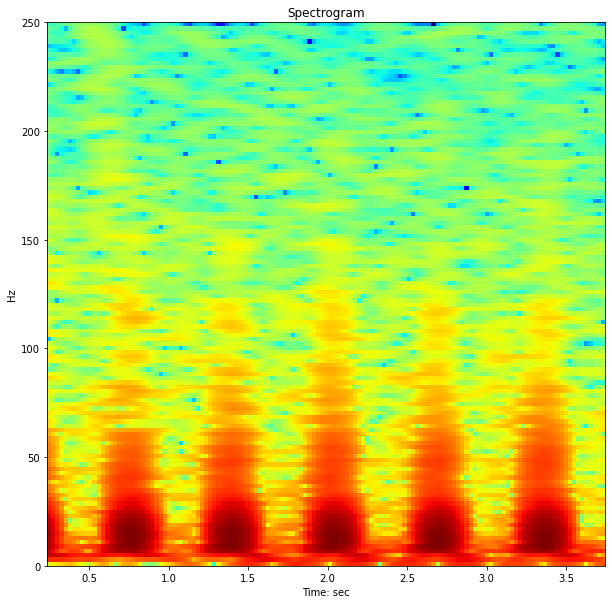

In [ ]:
plt.figure(figsize=(10, 10))
s,f,t,im = plt.specgram(highpass_inte, Fs=500,cmap='jet', NFFT=int(250), noverlap=int(250*0.95))
#plt.ylim(0,120)
plt.title("Spectrogram")
plt.xlabel("Time: sec")
plt.ylabel("Hz")

NameError: name 'axs' is not defined

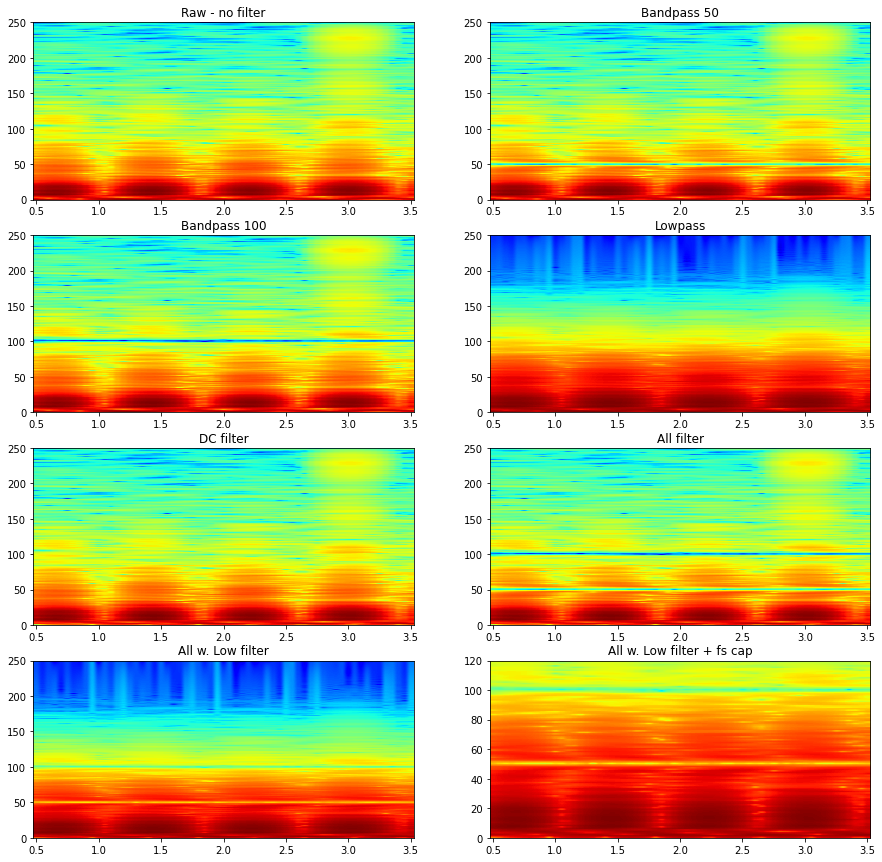

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(15,15), sharey=False, sharex = False)
Pxx, freqs, bins, im = ax1.specgram(sze, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax1.set_title('Raw - no filter')
Pxx, freqs, bins, im = ax2.specgram(band_pass_50, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax2.set_title('Bandpass 50')
Pxx, freqs, bins, im = ax3.specgram(band_pass_100, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax3.set_title('Bandpass 100')
Pxx, freqs, bins, im = ax4.specgram(lowpass, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax4.set_title('Lowpass')
Pxx, freqs, bins, im = ax5.specgram(highpass, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax5.set_title('DC filter')
Pxx, freqs, bins, im = ax6.specgram(all, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax6.set_title('All filter')
Pxx, freqs, bins, im = ax7.specgram(all_low, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet')
ax7.set_title('All w. Low filter')
Pxx, freqs, bins, im = ax8.specgram(all_low, NFFT=500, Fs=500, noverlap=int(500 * 0.95), cmap='jet', scale_by_freq=False)
ax8.axis(ymin=0, ymax=120)
ax8.set_title('All w. Low filter + fs cap')


for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Hz')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
all_inte = butter_bandstop_filter(inte, 97, 103, FREQ, order=6)
all_inte = butter_bandstop_filter(all_inte, 47, 53, FREQ, order=6)
all_inte = butter_highpass_filter(all_inte, 1, FREQ, order=6)

In [ ]:
den_sz = denoise_wavelet(np.array(sze).astype(np.float),wavelet='db6', method='BayesShrink', mode='hard',rescale_sigma=True, multichannel=False, wavelet_levels=1)
den_inte = denoise_wavelet(np.array(inte).astype(np.float),wavelet='db6', method='BayesShrink', mode='soft',rescale_sigma=True, multichannel=False, wavelet_levels=1)

all_den_sz = butter_bandstop_filter(den_sz, 97, 103, FREQ, order=6)
all_den_sz = butter_bandstop_filter(all_den_sz, 47, 53, FREQ, order=6)
all_den_sz = butter_highpass_filter(all_den_sz, 1, FREQ, order=6)

all_den_inte = butter_bandstop_filter(den_inte, 97, 103, FREQ, order=6)
all_den_inte = butter_bandstop_filter(all_den_inte, 47, 53, FREQ, order=6)
all_den_inte = butter_highpass_filter(all_den_inte, 1, FREQ, order=6)

all_low_sz = butter_bandstop_filter(sze, 97, 103, FREQ, order=6)
all_low_sz = butter_bandstop_filter(all_low_sz, 47, 53, FREQ, order=6)
all_low_sz = butter_highpass_filter(all_low_sz, 1, FREQ, order=6)
all_low_sz = butter_lowpass_filter(all_low_sz, 100, 500, order=1)

all_low_inte = butter_bandstop_filter(inte, 97, 103, FREQ, order=6)
all_low_inte = butter_bandstop_filter(all_low_inte, 47, 53, FREQ, order=6)
all_low_inte = butter_highpass_filter(all_low_inte, 1, FREQ, order=6)
all_low_inte = butter_lowpass_filter(all_low_inte, 100, 500, order=1)

Text(0.5, 1.0, 'low all int')

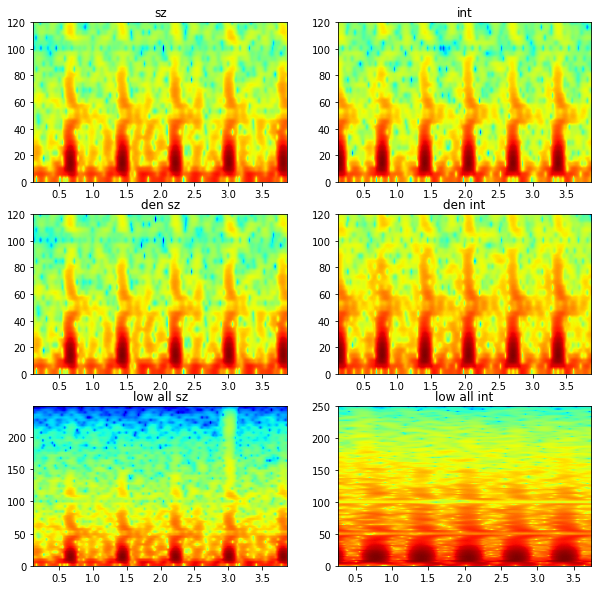

In [ ]:
nft = int(FREQ/4)
nover = int(nft*0.95)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10,10), sharey=False, sharex = False)
Pxx, freqs, bins, im = ax1.specgram(all, NFFT=nft, Fs=500, noverlap=nover, cmap='jet')
ax1.set_title('sz')
ax1.axis(ymin=0, ymax=120)
Pxx, freqs, bins, im = ax2.specgram(all_inte, NFFT=nft, Fs=500, noverlap=nover, cmap='jet')
ax2.set_title('int')
ax2.axis(ymin=0, ymax=120)

Pxx, freqs, bins, im = ax3.specgram(all_den_sz, NFFT=nft, Fs=500, noverlap=nover, cmap='jet')
ax3.set_title('den sz')
ax3.axis(ymin=0, ymax=120)
Pxx, freqs, bins, im = ax4.specgram(all_den_inte, NFFT=nft, Fs=500, noverlap=nover, cmap='jet')
ax4.set_title('den int')
ax4.axis(ymin=0, ymax=120)

Pxx, freqs, bins, im = ax5.specgram(all_low_sz, NFFT=nft, Fs=500, noverlap=nover, cmap='jet')
ax5.set_title('low all sz')
#ax5.axis(ymin=0, ymax=120)
Pxx, freqs, bins, im = ax6.specgram(all_low_inte, NFFT=256, Fs=500, noverlap=int(256*0.99), cmap='jet')
ax6.set_title('low all int')
#ax6.axis(ymin=0, ymax=120)




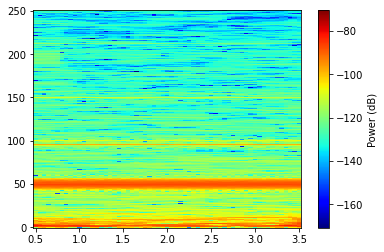

In [ ]:
import matplotlib
import pylab
import matplotlib.colors as colors
from scipy.stats import lognorm

Fs = 500       # Define the sampling frequency,
interval = 500   # ... the interval size,
overlap = interval * 0.95  # ... and the overlap intervals

f, t, Sxx = signal.spectrogram(np.array(sz_win[0][0]), fs=Fs, nperseg=interval, noverlap=overlap)

#normalize_color= colors.LogNorm(vmin=np.amin(Sxx), vmax=np.amax(Sxx))
Sxx = 10*np.log10(Sxx)
plt.pcolormesh(t, f, Sxx, cmap='jet')# Plot the result
plt.colorbar(label='Power (dB)')
#plt.savefig("hi2.png")


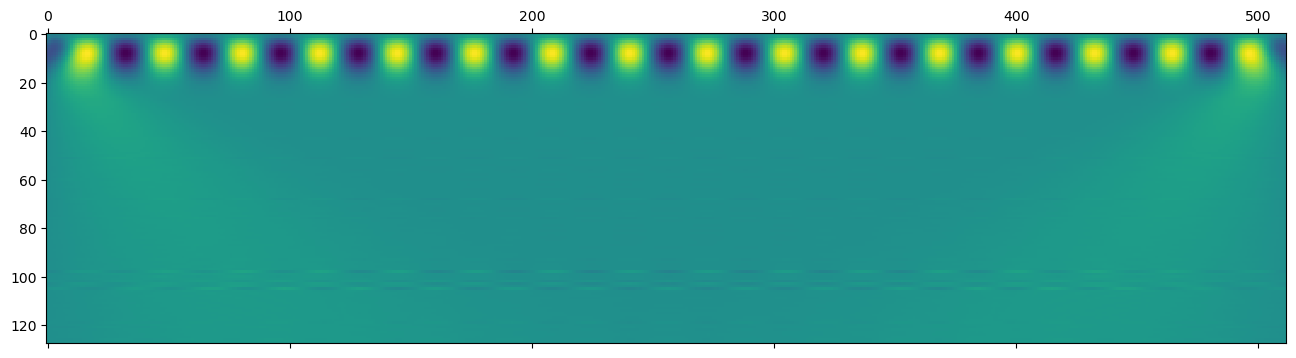

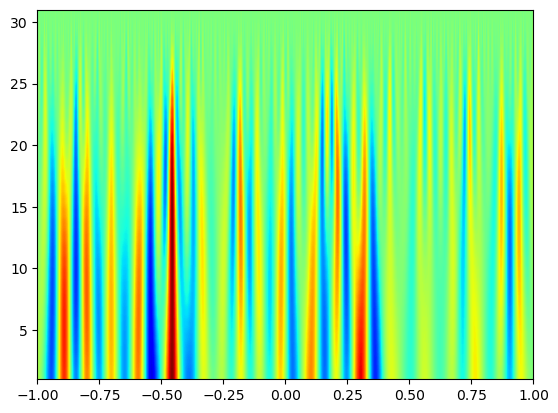

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(512)
y = np.sin(2*np.pi*x/32)
coef, freqs=pywt.cwt(y,np.arange(1,129),'gaus1')
plt.matshow(coef) # doctest: +SKIP
plt.show() # doctest: +SKIP

import pywt
import numpy as np
import matplotlib.pyplot as plt
t = np.linspace(-1, 1, 200, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + np.real(np.exp(-7*(t-0.4)**2)*np.exp(1j*2*np.pi*2*(t-0.4)))
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(inte, widths, 'mexh')
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='jet', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
plt.show() # doctest: +SKIP

In [ ]:
# Filtro taglia banda
def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    i, u = signal.butter(order, [low, high], btype='bandstop')
    y = signal.lfilter(i, u, data)
    return y

# Filtro taglia banda, passa alta
def butter_highpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    y = signal.lfilter(b, a, data)
    return y

In [ ]:
lowcut=117
highcut=123
fs=500

y=butter_bandstop_filter(sz_win[1][0], lowcut, highcut, fs, order=6)
lowcut=57
highcut=63
y=butter_bandstop_filter(y, lowcut, highcut, fs, order=6)

cutoff=1
y=butter_highpass_filter(y, cutoff, fs, order=6)

freqs, bins,Pxx =signal.spectrogram(np.array(y), nfft=1024, fs=500, return_onesided=True, noverlap=250)
Pxx = np.delete(Pxx, np.s_[117:123+1], axis=0)
Pxx = np.delete(Pxx, np.s_[57:63+1], axis=0)
Pxx = np.delete(Pxx, 0, axis=0)
freqs = np.arange(Pxx.shape[0])
result=(10*np.log10(np.transpose(Pxx))-(10*np.log10(np.transpose(Pxx))).min())/(10*np.log10(np.transpose(Pxx))).ptp()
plt.pcolormesh(freqs, bins, result,cmap=plt.cm.jet)

NameError: name 'butter_bandstop_filter' is not defined